In [1]:
from IPython.display import clear_output
!pip install --upgrade luxai_s2
!pip install pettingzoo==1.12.0 gym==0.21.0 stable-baselines3
!pip install --upgrade "importlib_metadata<5.0"
!pip install sb3_contrib
clear_output()

In [2]:
%%writefile /opt/conda/lib/python3.7/site-packages/luxai_s2/version.py
__version__ = ""
# this code above is used for Kaggle Notebooks
# You might not need to run this but if you get an attribute error about the gym package, run it

Overwriting /opt/conda/lib/python3.7/site-packages/luxai_s2/version.py


In [3]:
import importlib
import importlib_metadata
# kaggle has 6.0.0 installed but we need version <5.0
importlib.reload(importlib_metadata)

<module 'importlib_metadata' from '/opt/conda/lib/python3.7/site-packages/importlib_metadata/__init__.py'>

Remember to ``"Restart & clear cell outputs"`` at this time

In [4]:
# Common imports 
import numpy as np
import numpy.typing as npt
import torch as th
import matplotlib.pyplot as plt
import os.path as osp

from typing import Any, Dict, Callable, Optional

# LuxAI imports
from luxai_s2.env import LuxAI_S2
from lux.config import EnvConfig
from luxai_s2.state import ObservationStateDict
from luxai_s2.unit import UnitType, UnitStateDict, ActionType, BidActionType, FactoryPlacementActionType
from luxai_s2.utils import my_turn_to_place_factory
from luxai_s2.wrappers.controllers import Controller

# Gym imports
import gym
from gym import spaces
from gym import ActionWrapper, ObservationWrapper, RewardWrapper, Wrapper
from gym.wrappers import TimeLimit

# SB3 imports
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.monitor import Monitor

# SB3-contrib imports
from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy

pygame 2.3.0 (SDL 2.24.2, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


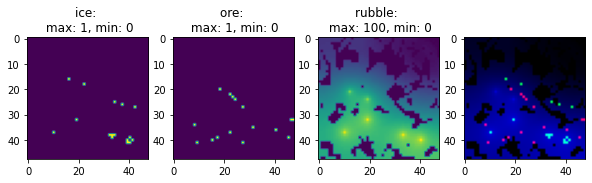

In [5]:
env = LuxAI_S2() # Load environment
obs = env.reset(12412) # Reset environment -> first observation
board = obs['player_0']['board'] # Get board

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10,3))
ax[0].imshow(board['ice']) # Show ice
ax[0].set_title(f"ice: \n max: {np.max(board['ice'])}, min: {np.min(board['ice'])}")
ax[1].imshow(board['ore']) # Show ore
ax[1].set_title(f"ore: \n max: {np.max(board['ore'])}, min: {np.min(board['ore'])}")
ax[2].imshow(board['rubble']) # Show rubble
ax[2].set_title(f"rubble: \n max: {np.max(board['rubble'])}, min: {np.min(board['rubble'])}")
ax[3].imshow(np.stack([board['ore'],board['ice'],board['rubble']/100],axis=2))

plt.show()

In [6]:
env_cfg = env.env_cfg
# a = env_cfg.ROBOTS["HEAVY" if UnitType == "HEAVY" else "LIGHT"].BATTERY_CAPACITY
# a

In [7]:
# Controller class copied here since you won't have access to the luxai_s2 package directly on the competition server
class Controller:
    def __init__(self, action_space: spaces.Space) -> None:
        self.action_space = action_space

    def action_to_lux_action(self, agent: str, obs: Dict[str, Any], action: npt.NDArray):
        """
        Takes as input the current "raw observation" and the parameterized action and returns
        an action formatted for the Lux env
        """
        raise NotImplementedError()

    def get_action_masks(self, agent: str, obs: Dict[str, Any]):
        """
        Generates a boolean action mask indicating in each discrete dimension whether it would be valid or not
        """
        raise NotImplementedError()

In [8]:
class SimpleUnitDiscreteController(Controller):
    def __init__(self, env_cfg) -> None:

        self.env_cfg = env_cfg
        self.move_act_dims = 4
        self.transfer_act_dims = 5
        self.pickup_act_dims = 1
        self.dig_act_dims = 1
        self.no_op_dims = 1

        # added_version
        self.self_destruct_act_dims = 1
        self.recharge_act_dims = 1
        self.facotory_act_dims = 3
        '''planning, factory actions, transferring power or resources other than ice 추가필요'''
        # end
        

        self.move_dim_high = self.move_act_dims 
        self.transfer_dim_high = self.move_dim_high + self.transfer_act_dims 
        self.pickup_dim_high = self.transfer_dim_high + self.pickup_act_dims 
        self.dig_dim_high = self.pickup_dim_high + self.dig_act_dims 
        self.no_op_dim_high = self.dig_dim_high + self.no_op_dims 
        
        # added_version
        self.self_destruct_act_dim_high = self.no_op_dim_high + self.self_destruct_act_dims 
        self.recharge_act_dim_high = self.self_destruct_act_dim_high + self.recharge_act_dims 
        self.facotory_act_dim_high = self.recharge_act_dim_high + self.facotory_act_dims 
        
        self.total_dim_high = self.facotory_act_dim_high
        
        # end
        self.total_act_dims = self.total_dim_high
        action_space = spaces.Discrete(self.total_act_dims)
        super().__init__(action_space)

    def _is_move_action(self, id):
        return id < self.move_dim_high

    def _get_move_action(self, id):
        # move direction is id + 1 since we don't allow move center here
        return np.array([0, id + 1, 0, 0, 0, 1])
# R = resource type (0 = ice, 1 = ore, 2 = water, 3 = metal, 4 power)

# transfer_added_version
    def _is_transfer_action_ice(self, id):
        return id < self.transfer_dim_high
    
    def _get_transfer_action_ice(self, id):
        id = id - self.move_dim_high
        transfer_dir = id % 5
        return np.array([1, transfer_dir, 0, self.env_cfg.max_transfer_amount, 0, 1])
    
    def _is_transfer_action_ore(self, id):
        return id < self.transfer_dim_high

    def _get_transfer_action_ore(self, id):
        id = id - self.move_dim_high
        transfer_dir = id % 5
        return np.array([1, transfer_dir, 1, self.env_cfg.max_transfer_amount, 0, 1])
    
    def _is_transfer_action_water(self, id):
        return id < self.transfer_dim_high

    def _get_transfer_action_water(self, id):
        id = id - self.move_dim_high
        transfer_dir = id % 5
        return np.array([1, transfer_dir, 2, self.env_cfg.max_transfer_amount, 0, 1])
    
    def _is_transfer_action_metal(self, id):
        return id < self.transfer_dim_high

    def _get_transfer_action_metal(self, id):
        id = id - self.move_dim_high
        transfer_dir = id % 5
        return np.array([1, transfer_dir, 3, self.env_cfg.max_transfer_amount, 0, 1])
    
    def _is_transfer_action_power(self, id):
        return id < self.transfer_dim_high
    
    def _get_transfer_action_power(self, id):
        id = id - self.move_dim_high
        transfer_dir = id % 5
        return np.array([1, transfer_dir, 4, self.env_cfg.max_transfer_amount, 0, 1])
    
    # end
    
    # pickup_added_version
    
    def _is_pickup_action_ice(self, id):
        return id < self.pickup_dim_high

    def _get_pickup_action_ice(self, id):
        return np.array([2, 0, 0, self.env_cfg.max_transfer_amount, 0, 1])
    
    def _is_pickup_action_ore(self, id):
        return id < self.pickup_dim_high

    def _get_pickup_action_ore(self, id):
        return np.array([2, 0, 1, self.env_cfg.max_transfer_amount, 0, 1])
    
    def _is_pickup_action_water(self, id):
        return id < self.pickup_dim_high

    def _get_pickup_action_water(self, id):
        return np.array([2, 0, 2, self.env_cfg.max_transfer_amount, 0, 1])
    
    def _is_pickup_action_metal(self, id):
        return id < self.pickup_dim_high

    def _get_pickup_action_metal(self, id):
        return np.array([2, 0, 3, self.env_cfg.max_transfer_amount, 0, 1])
    
    def _is_pickup_action_power(self, id):
        return id < self.pickup_dim_high

    def _get_pickup_action_power(self, id):
        return np.array([2, 0, 4, self.env_cfg.max_transfer_amount, 0, 1])
    
    # end
    
    # dig_added_version
    
    def _is_dig_action_ice(self, id):
        return id < self.dig_dim_high

    def _get_dig_action_ice(self, id):
        return np.array([3, 0, 0, self.env_cfg.ROBOTS["HEAVY" if UnitType == "HEAVY" else "LIGHT"].CARGO_SPACE, 0, 1])
    
    def _is_dig_action_ore(self, id):
        return id < self.dig_dim_high

    def _get_dig_action_ore(self, id):
        return np.array([3, 0, 1, self.env_cfg.ROBOTS["HEAVY" if UnitType == "HEAVY" else "LIGHT"].CARGO_SPACE, 0, 1])
    
    # end
    
    def action_to_lux_action(
        self, agent: str, obs: Dict[str, Any], action: npt.NDArray
        
    ):  
        shared_obs = obs["player_0"]
        lux_action = dict()
        units = shared_obs["units"][agent]
        for unit_id in units.keys():
            unit = units[unit_id]
            choice = action
            action_queue = []
            no_op = False
            if self._is_move_action(choice):
                action_queue = [self._get_move_action(choice)]
            # added_version
            
            elif self._is_transfer_action_ice(choice):
                action_queue = [self._get_transfer_action_ice(choice)]
                
            elif self._is_transfer_action_ore(choice):
                action_queue = [self._get_transfer_action_ore(choice)]
                
            elif self._is_transfer_action_water(choice):
                action_queue = [self._get_transfer_action_water(choice)]
            
            elif self._is_transfer_action_metal(choice):
                action_queue = [self._get_transfer_action_metal(choice)]
                
            elif self._is_transfer_action_power(choice):
                action_queue = [self._get_transfer_action_power(choice)]    
            # end
            
            # added_version
            elif self._is_pickup_action_ice(choice):
                action_queue = [self._get_pickup_action_ice(choice)]
                
            elif self._is_pickup_action_ore(choice):
                action_queue = [self._get_pickup_action_ore(choice)]
            
            elif self._is_pickup_action_water(choice):
                action_queue = [self._get_pickup_action_water(choice)]
                
            elif self._is_pickup_action_metal(choice):
                action_queue = [self._get_pickup_action_metal(choice)]
                
            elif self._is_pickup_action_power(choice):
                action_queue = [self._get_pickup_action_power(choice)]
            
            # end
            
            # added_version
                
            elif self._is_dig_action_ice(choice):
                action_queue = [self._get_dig_action_ice(choice)]
            
            elif self._is_dig_action_ore(choice):
                action_queue = [self._get_dig_action_ore(choice)]
                
            # end
                 
#             elif self._is_recharge_action(choice):
#                 action_queue = [self._get_recharge_action(choice)]
#             elif self._is_self_destruct_action(choice):
#                 action_queue = [self._get_self_destruct_action(choice)]
            else:
                # action is a no_op, so we don't update the action queue
                no_op = True

            # simple trick to help agents conserve power is to avoid updating the action queue
            # if the agent was previously trying to do that particular action already
            if len(unit["action_queue"]) > 0 and len(action_queue) > 0:
                same_actions = (unit["action_queue"][0] == action_queue[0]).all() # 리스트 내에 모든 요소가 비슷한지 아닌지 
                if same_actions:
                    no_op = True
            if not no_op:
                lux_action[unit_id] = action_queue

            break

        factories = shared_obs["factories"][agent]
        units = shared_obs["units"][agent]
        
        if len(units) == 0:
            for unit_id in factories:
                factory = factories[unit_id]
                if factory["cargo"]["metal"] >= 100:
                    lux_action[unit_id] = 1
                    
        
        return lux_action
     
    def action_masks(self, agent: str, obs: Dict[str, Any]):
        shared_obs = obs[agent]
        factory_occupancy_map = (
            np.ones_like(shared_obs["board"]["rubble"], dtype=int) * -1
        )
        factories = dict()
        for player in shared_obs["factories"]:
            factories[player] = dict()
            for unit_id in shared_obs["factories"][player]:
                f_data = shared_obs["factories"][player][unit_id]
                f_pos = f_data["pos"]
                # store in a 3x3 space around the factory position it's strain id.
                factory_occupancy_map[
                    f_pos[0] - 1 : f_pos[0] + 2, f_pos[1] - 1 : f_pos[1] + 2
                ] = f_data["strain_id"]

        units = shared_obs["units"][agent]
        action_mask = np.zeros((self.total_act_dims), dtype=bool)
        for unit_id in units.keys():
            action_mask = np.zeros(self.total_act_dims)
            # movement is always valid
            action_mask[:4] = True

            # transferring is valid only if the target exists
            unit = units[unit_id]
            pos = np.array(unit["pos"])
            # a[1] = direction (0 = center, 1 = up, 2 = right, 3 = down, 4 = left)
            move_deltas = np.array([[0, 0], [0, -1], [1, 0], [0, 1], [-1, 0]])
            for i, move_delta in enumerate(move_deltas):
                transfer_pos = np.array(
                    [pos[0] + move_delta[0], pos[1] + move_delta[1]]
                )
                # check if theres a factory tile there
                if (
                    transfer_pos[0] < 0
                    or transfer_pos[1] < 0
                    or transfer_pos[0] >= len(factory_occupancy_map)
                    or transfer_pos[1] >= len(factory_occupancy_map[0])
                ):
                    continue
                factory_there = factory_occupancy_map[transfer_pos[0], transfer_pos[1]]
                if factory_there in shared_obs["teams"][agent]["factory_strains"]:
                    action_mask[
                        self.transfer_dim_high - self.transfer_act_dims + i
                    ] = True

            factory_there = factory_occupancy_map[pos[0], pos[1]]
            on_top_of_factory = (
                factory_there in shared_obs["teams"][agent]["factory_strains"]
            )

            # dig is valid only if on top of tile with rubble or resources or lichen
            board_sum = (
                shared_obs["board"]["ice"][pos[0], pos[1]]
                + shared_obs["board"]["ore"][pos[0], pos[1]]
                + shared_obs["board"]["rubble"][pos[0], pos[1]]
                + shared_obs["board"]["lichen"][pos[0], pos[1]]
            )
            if board_sum > 0 and not on_top_of_factory:
                action_mask[
                    self.dig_dim_high - self.dig_act_dims : self.dig_dim_high
                ] = True

            # pickup is valid only if on top of factory tile
            if on_top_of_factory:
                action_mask[
                    self.pickup_dim_high - self.pickup_act_dims : self.pickup_dim_high
                ] = True
                action_mask[
                    self.dig_dim_high - self.dig_act_dims : self.dig_dim_high
                ] = False

            # no-op is always valid
            action_mask[-1] = True
            break
        return np.array(action_mask, dtype=bool)

In [9]:
def bin_array(num, m):
    """Convert a positive integer num into an m-bit bit vector"""
    return np.array(list(np.binary_repr(num).zfill(m))).astype(np.int8)


class RTSObservationWrapper(gym.ObservationWrapper):
    """Each agent just sees its own factories and units.

    Unit type 2 (factory, heavy, noop)
    Cargo Ice: 10 (heavy) 2**10
    Resources: 1 (ice)

    For example, a cell where a factory and a heavy robot is located,
    robot has 1 ice and the cell has no ice:

    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ]

    """

    def __init__(self, env: gym.Env) -> None:
        super().__init__(env)
        self.observation_space = spaces.Box(
            0, 1, shape=(24, env.env_cfg.map_size, env.env_cfg.map_size), dtype=np.int8
        )

    def observation(self, obs):
        return RTSObservationWrapper.convert_obs(obs, self.env.state.env_cfg)

    # we make this method static so the submission/evaluation code can use this as well
    @staticmethod
    def convert_obs(obs: Dict[str, Any], env_cfg: Any) -> Dict[str, npt.NDArray]:
        observation = dict()
        shared_obs = obs["player_0"]

        ice_map = np.array(shared_obs["board"]["ice"], dtype=int)
        ice_map = np.expand_dims(ice_map, axis=0)

        ice_cargo = np.zeros((10, env_cfg.map_size, env_cfg.map_size))
        
        ore_map = np.array(shared_obs["board"]["ore"], dtype=int)
        ore_map = np.expand_dims(ore_map, axis=0)

        ore_cargo = np.zeros((10, env_cfg.map_size, env_cfg.map_size))
        
        
        

        for agent in obs.keys():
            factory_location = np.zeros(
                shape=(1, env_cfg.map_size, env_cfg.map_size), dtype=np.int8
            )
            unit_location = np.zeros(
                shape=(1, env_cfg.map_size, env_cfg.map_size), dtype=np.int8
            )

            factories = shared_obs["factories"][agent]

            for k in factories.keys():
                factory = factories[k]
                factory_pos_x, factory_pos_y = factory["pos"]
                factory_location[:, factory_pos_x, factory_pos_y] = 1

            units = shared_obs["units"][agent]
            for k in units.keys():
                unit = units[k]
                unit_pos_x, unit_pos_y = unit["pos"]

                unit_location[:, unit_pos_x, unit_pos_y] = 1

                unit_ice_cargo = int(unit["cargo"]["ice"])

                ice_cargo[:, unit_pos_x, unit_pos_y] = bin_array(
                    unit_ice_cargo, ice_cargo.shape[0]
                )
                
                unit_ore_cargo = int(unit["cargo"]["ore"])

                ore_cargo[:, unit_pos_x, unit_pos_y] = bin_array(
                    unit_ore_cargo, ore_cargo.shape[0]
                )
                

            agent_observation = np.concatenate(
                [factory_location, unit_location, ice_map, ice_cargo, ore_map, ore_cargo],
                axis=0,
            )

            observation[agent] = agent_observation

        return observation

In [10]:
from luxai_s2.wrappers import SB3Wrapper
import copy
class SB3InvalidActionWrapper(SB3Wrapper):
    def __init__(
        self,
        env: LuxAI_S2,
        bid_policy: Callable[
            [str, ObservationStateDict], Dict[str, BidActionType]
        ] = None,
        factory_placement_policy: Callable[
            [str, ObservationStateDict], Dict[str, FactoryPlacementActionType]
        ] = None,
        controller: Controller = None,
    ) -> None:
        super().__init__(env, bid_policy, factory_placement_policy, controller)
    
    def action_masks(self):
        return self.controller.action_masks('player_0', self.prev_obs)

class CustomEnvWrapper(gym.Wrapper):
    def __init__(self, env: gym.Env) -> None:
        """
        Adds a custom reward and turns the LuxAI_S2 environment into a single-agent environment for easy training
        """
        super().__init__(env)
        self.prev_step_metrics = None

    def step(self, action):
        agent = "player_0"
        opp_agent = "player_1"

        opp_factories = self.env.state.factories[opp_agent]
        for k in opp_factories.keys():
            factory = opp_factories[k]
            # set enemy factories to have 1000 water to keep them alive the whole around and treat the game as single-agent
            factory.cargo.water = 1000

        # submit actions for just one agent to make it single-agent
        # and save single-agent versions of the data below
        action = {agent: action}
        obs, _, done, info = self.env.step(action)
        obs = obs[agent]
        done = done[agent]

        # we collect stats on teams here. These are useful stats that can be used to help generate reward functions
        stats: StatsStateDict = self.env.state.stats[agent]

        info = dict()
        metrics = dict()
        metrics["ice_dug"] = (
            stats["generation"]["ice"]["HEAVY"] + stats["generation"]["ice"]["LIGHT"]
        )
        metrics["ore_dug"] = (
            stats["generation"]["ore"]["HEAVY"] + stats["generation"]["ore"]["LIGHT"]
        )
        
        
        metrics["water_produced"] = stats["generation"]["water"]
        metrics["metal_produced"] = stats["generation"]["metal"] 

        # we save these two to see often the agent updates robot action queues and how often enough
        # power to do so and succeed (less frequent updates = more power is saved)
        metrics["action_queue_updates_success"] = stats["action_queue_updates_success"]
        metrics["action_queue_updates_total"] = stats["action_queue_updates_total"]

        # we can save the metrics to info so we can use tensorboard to log them to get a glimpse into how our agent is behaving
        info["metrics"] = metrics

        reward = 0
        if self.prev_step_metrics is not None:
            # we check how much ice and water is produced and reward the agent for generating both
            ice_dug_this_step = metrics["ice_dug"] - self.prev_step_metrics["ice_dug"]
            
            # added_version
            ore_dug_this_step = metrics["ore_dug"] - self.prev_step_metrics["ore_dug"]
#             water_dug_this_step = metrics["water_dug"] - self.prev_step_metrics["water_dug"]
#             metal_dug_this_step = metrics["metal_dug"] - self.prev_step_metrics["ice_dug"]
            
            
            
            
            
            water_produced_this_step = (
                metrics["water_produced"] - self.prev_step_metrics["water_produced"]
            )
            metal_produced_this_step = (
                metrics["metal_produced"] - self.prev_step_metrics["metal_produced"]
            )
            # we reward water production more as it is the most important resource for survival
            reward = ice_dug_this_step / 100 + water_produced_this_step
            reward = ore_dug_this_step / 100 + metal_produced_this_step
            
        self.prev_step_metrics = copy.deepcopy(metrics)
        return obs, reward, done, info

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)["player_0"]
        self.prev_step_metrics = None
        return obs

### Defining a Bid, Factory Placement, and Factory Build

To test the code above, we can program some heuristic bid and factory placement policies

In [11]:
def zero_bid(player, obs):
    # a policy that always bids 0
    faction = "AlphaStrike"
    if player == "player_1":
        faction = "MotherMars"
    return dict(bid=0, faction=faction)

def place_near_random_ice(player, obs):
    """
    This policy will place a single factory with all the starting resources
    near a random ice tile
    """
    if obs["teams"][player]["metal"] == 0:
        return dict()
    potential_spawns = list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1)))
    potential_spawns_set = set(potential_spawns)
    done_search = False
    
    # simple numpy trick to find locations adjacent to ice tiles.
    ice_diff = np.diff(obs["board"]["ice"])
    pot_ice_spots = np.argwhere(ice_diff == 1)
    if len(pot_ice_spots) == 0:
        pot_ice_spots = potential_spawns
    
    # pick a random ice spot and search around it for spawnable locations.
    trials = 5
    while trials > 0:
        pos_idx = np.random.randint(0, len(pot_ice_spots))
        pos = pot_ice_spots[pos_idx]
        area = 3
        for x in range(area):
            for y in range(area):
                check_pos = [pos[0] + x - area // 2, pos[1] + y - area // 2]
                if tuple(check_pos) in potential_spawns_set:
                    done_search = True
                    pos = check_pos
                    break
            if done_search:
                break
        if done_search:
            break
        trials -= 1
    
    if not done_search:
        spawn_loc = potential_spawns[np.random.randint(0, len(potential_spawns))]
        pos = spawn_loc
    
    # this will spawn a factory at pos and with all the starting metal and water
    metal = obs["teams"][player]["metal"]
    return dict(spawn=pos, metal=metal, water=metal)


# added_version
def build_Robot(agent, obs: ObservationStateDict):
    actions = dict()
    if agent == "player_0":
        factories = obs["factories"][agent]
        units = obs["units"][agent]
        if len(units) == 0:
            for unit_id in factories:
                factory = factories[unit_id]
                if factory["cargo"]["metal"] >= 10 and factory["cargo"]['power'] >= 50:
                    actions[unit_id] = 0
        elif len(units) == 4:
            for unit_id in factories:
                factory = factories[unit_id]
                if factory["cargo"]["metal"] >= 100 and factory["cargo"]['power'] >= 500:
                    actions[unit_id] = 1
#         elif len(units) % 3 == 0:
#             for unit_id in factories:
#                     actions[unit_id] = 2
                    

    return actions

# end

In [12]:
def make_env(env_id: str, rank: int, seed: int = 0, max_episode_steps=1000):
    def _init() -> gym.Env:
        # verbose = 0
        # collect stats so we can create reward functions
        # max factories set to 2 for simplification and keeping returns consistent as we survive longer if there are more initial resources
        env = gym.make(env_id, verbose=0, collect_stats=True, MAX_FACTORIES=5)

        # Add a SB3 wrapper to make it work with SB3 and simplify the action space with the controller
        # this will remove the bidding phase and factory placement phase. For factory placement we use
        # the provided place_near_random_ice function which will randomly select an ice tile and place a factory near it.

        env = SB3InvalidActionWrapper(
            env,
            factory_placement_policy=place_near_random_ice,
            controller=SimpleUnitDiscreteController(env.env_cfg),

        )
        env = RTSObservationWrapper(
            env
        )  # changes observation to include a few simple features
        env = CustomEnvWrapper(env)  # convert to single agent, add our reward
        env = TimeLimit(
            env, max_episode_steps=max_episode_steps
        )  # set horizon to 100 to make training faster. Default is 1000
        env = Monitor(env)  # for SB3 to allow it to record metrics
        env.reset(seed=seed + rank)
        set_random_seed(seed)
        return env

    return _init

In [13]:
def animate(imgs, video_name=None, _return=True):
    # using cv2 to generate videos
    import cv2
    import os
    import string
    import random
    video_name = video_name if video_name is not None else ''.join(random.choice(string.ascii_letters) for i in range(18))+'.webm'
    height, width, layers = imgs[0].shape
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'VP80'), 20, (width,height))
    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)

In [14]:
import copy
env = make_env("LuxAI_S2-v0", 0, 0, max_episode_steps=300)()
obs = env.reset() # always reset before starting a new episode!
imgs = []
for i in range(300):  # 1000이 아닐까?
    action = env.action_space.sample() # sample a random action
    obs, reward, done, info = env.step(action) # get the new observation and reward
    imgs += [env.render("rgb_array")] # save to video
    if done: env.reset()
env.close() # close the display window and free up resources
animate(imgs, "random_interaction.webm") # generate the video replay

OpenCV: FFMPEG: tag 0x30385056/'VP80' is not supported with codec id 139 and format 'webm / WebM'


Next we will define a useful callback function to log some of the custom metrics we defined earlier in the CustomEnvWrapper

In [15]:
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
class TensorboardCallback(BaseCallback):
    def __init__(self, tag: str, verbose=0):
        super().__init__(verbose)
        self.tag = tag

    def _on_step(self) -> bool:
        c = 0

        for i, done in enumerate(self.locals["dones"]):
            if done:
                info = self.locals["infos"][i]
                c += 1
                for k in info["metrics"]:
                    stat = info["metrics"][k]
                    self.logger.record_mean(f"{self.tag}/{k}", stat)
        return True

In [16]:
import gym
import torch as th
import torch.nn as nn

from stable_baselines3 import PPO

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
class NatureCNN(BaseFeaturesExtractor):
    """
    CNN from DQN Nature paper:
        Mnih, Volodymyr, et al.
        "Human-level control through deep reinforcement learning."
        Nature 518.7540 (2015): 529-533.
    :param observation_space:
    :param features_dim: Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(
        self,
        observation_space: spaces.Box,
        features_dim: int = 512,
    ) -> None:
        super().__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))
    
policy_kwargs = dict(
    features_extractor_class=NatureCNN,
    features_extractor_kwargs=dict(features_dim=128),
    net_arch=(64, 64),
)

In [17]:
from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy

set_random_seed(0)
env_id = 'LuxAI_S2-v0'
log_path = "logs/exp_mppo"
n_envs = 4

# set max episode steps to 200 for training environments to train faster
train_max_episode_steps=200
eval_max_episode_steps=1000

# set Invalid action masking approach
invalid_action_masking=True

# CAUTION: MaskablePPO only works with DummyVecEnv.
# To implement multiprocessing using SubprocEnv, there is a current issue in GitHub at 
# https://github.com/Stable-Baselines-Team/stable-baselines3-contrib/issues/49

environments = [make_env(env_id, i, max_episode_steps=train_max_episode_steps) for i in range(n_envs)]
env = DummyVecEnv(environments) if invalid_action_masking else SubprocVecEnv(environments)
env.reset()

# set max episode steps to 1000 to match original environment
eval_environments = [make_env(env_id, i, max_episode_steps=eval_max_episode_steps) for i in range(4)]
eval_env = DummyVecEnv(eval_environments) if invalid_action_masking else SubprocVecEnv(eval_environments)
eval_env.reset()

rollout_steps = 4000
policy_kwargs = dict(net_arch=(128, 128))

model_params = {
        'policy' : "MlpPolicy",
        'env' : env,
        'n_steps':rollout_steps // n_envs,
        'batch_size':800,
        'learning_rate':3e-4,
        'policy_kwargs':policy_kwargs,
        'verbose':1,
        'n_epochs':2,
        'target_kl':0.05,
        'gamma':0.99,
        'tensorboard_log':osp.join(log_path)
    }

model = MaskablePPO(**model_params) if invalid_action_masking else PPO(**model_params)

print("Training model: {}".format(type(model)))

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=osp.join(log_path, "models"), # 최고 성능을 보인 모델의 저장 결로를 지정하는 인수
    log_path=osp.join(log_path, "eval_logs"), # 로그 파일을 저장할 경로를 지정하는 인수
    eval_freq=12_000, # 평가 간격을 지정하는 인수 / 코드의 가독성을 높이기 위해서 사용되는 문법
    deterministic=False, # 평가에 사용되는 액션을 확률적으로 선택할 것인지를 결정하는 인수
    render=False, # 평가 중에 게임 화면을 렌더링할 것인지를 결정
    n_eval_episodes=5, # 각, 평가 단계에서 실행한 에피소드 수를 지정하는 인수
)

Using cpu device
Training model: <class 'sb3_contrib.ppo_mask.ppo_mask.MaskablePPO'>


In [18]:
import optuna

from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy

### Clean previous training model and envs ###

try:
    model.env.close()
    eval_env.close()
    env.close()
except Exception:
    pass

### Global configuration variables ###
rollout_steps = 4000
env_id = 'LuxAI_S2-v0'
log_path = "logs/exp_mppo"
n_envs = 4

total_timesteps = 300_000

eval_max_episode_steps=1000
eval_freq=24_000

invalid_action_masking=True

n_trials=10 # Optuna will use 10 trials
n_startup_trials=3 # Optuna will not use pruning or non-random sampling during these trials

n_evaluations = int(total_timesteps / eval_freq)  # Number of evaluations per train

class TrialEvalCallback(EvalCallback):
    """Monitor the mean eval reward so Optuna can optimize the hyperparameters."""
    def __init__(
        self,
        eval_env: gym.Env,
        trial: optuna.Trial,
        n_eval_episodes: int = 5,
        eval_freq: int = 10000,
        deterministic: bool = True,
        verbose: int = 0,
    ):
        super().__init__(
            eval_env=eval_env,
            n_eval_episodes=n_eval_episodes,
            eval_freq=eval_freq,
            deterministic=deterministic,
            verbose=verbose,
        )
        self.trial = trial
        self.eval_idx = 0
        self.is_pruned = False

    def _on_step(self) -> bool:
        if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
            super()._on_step()
            self.eval_idx += 1
            self.trial.report(self.last_mean_reward, self.eval_idx)
            if self.trial.should_prune():
                self.is_pruned = True
                return False
        return True

def sample_ppo_parameters(trial: optuna.Trial):
    """Get PPO parameters. Some suggested by Optuna based on Trials."""
    batch_size = 800

    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-03, log=True)

    n_epochs = trial.suggest_int("n_epochs", 2, 3)

    max_episode_steps = trial.suggest_int("max_episode_steps", 200, 1000)

    target_kl = 0.05

    gamma = 0.99

    output_paramaters = dict(
        learning_rate=learning_rate,
        n_epochs=n_epochs,
        max_episode_steps=max_episode_steps,
        target_kl=target_kl,
        gamma=gamma,
        batch_size=batch_size,
    )

    return output_paramaters

def objective(trial: optuna.Trial) -> float:
    """Set the objective for optuna to optimize.
    
    Notes
    -----
    In this case, the mean evaluation reward of the agent is optimized.
    
    """
    set_random_seed(0)

    policy_kwargs = dict(
        features_extractor_class=NatureCNN,
        features_extractor_kwargs=dict(features_dim=128),
        net_arch=(64, 64),
    )

    ppo_parameters = sample_ppo_parameters(trial)

    max_episode_steps = ppo_parameters.pop("max_episode_steps")

    environments = [make_env(env_id, i, max_episode_steps=max_episode_steps) for i in range(n_envs)]
    env = DummyVecEnv(environments) if invalid_action_masking else SubprocVecEnv(environments)
    env.reset()

    model = MaskablePPO(
        "CnnPolicy",
        env,
        n_steps=rollout_steps // n_envs,
        policy_kwargs=policy_kwargs,
        verbose=1,
        tensorboard_log=osp.join(log_path),
        **ppo_parameters,
    )

    eval_environments = [make_env(env_id, i, max_episode_steps=eval_max_episode_steps) for i in range(4)]
    eval_env = DummyVecEnv(eval_environments) if invalid_action_masking else SubprocVecEnv(eval_environments)
    eval_env.reset()

    eval_callback = TrialEvalCallback(
        eval_env,
        trial=trial,
        eval_freq=eval_freq,
        deterministic=False,
        n_eval_episodes=5,
    )

    try:
        model.learn(
            total_timesteps,
            callback=[TensorboardCallback(tag="train_metrics"), eval_callback],
        )
    finally:
        # Free memory.
        model.env.close()
        eval_env.close()
        env.close()

    return eval_callback.last_mean_reward

In [19]:
sampler = TPESampler(n_startup_trials=n_startup_trials)

# Do not prune before 1/3 of the max budget is used
pruner = MedianPruner(
    n_startup_trials=n_startup_trials,
    n_warmup_steps=n_evaluations // 3
)

# Create the study and start the hyperparameter optimization
study = optuna.create_study(
    sampler=sampler, pruner=pruner, direction="maximize"
)

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=1,
    timeout=None
)

[I 2023-04-21 08:38:19,464] A new study created in memory with name: no-name-e40929f8-105b-4dd5-8ff7-f640223ad0a7


Using cpu device
Logging to logs/exp_mppo/PPO_1
----------------------------------------------
| rollout/                        |          |
|    ep_len_mean                  | 542      |
|    ep_rew_mean                  | 0        |
| time/                           |          |
|    fps                          | 300      |
|    iterations                   | 1        |
|    time_elapsed                 | 13       |
|    total_timesteps              | 4000     |
| train_metrics/                  |          |
|    action_queue_updates_success | 271      |
|    action_queue_updates_total   | 424      |
|    ice_dug                      | 4        |
|    metal_produced               | 0        |
|    ore_dug                      | 0        |
|    water_produced               | 1        |
----------------------------------------------
---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 526          

[I 2023-04-21 09:00:49,378] Trial 0 finished with value: 0.0 and parameters: {'learning_rate': 0.0002097889818546018, 'n_epochs': 3, 'max_episode_steps': 779}. Best is trial 0 with value: 0.0.


Using cpu device
Logging to logs/exp_mppo/PPO_2
----------------------------------------------
| rollout/                        |          |
|    ep_len_mean                  | 251      |
|    ep_rew_mean                  | 0        |
| time/                           |          |
|    fps                          | 439      |
|    iterations                   | 1        |
|    time_elapsed                 | 9        |
|    total_timesteps              | 4000     |
| train_metrics/                  |          |
|    action_queue_updates_success | 130      |
|    action_queue_updates_total   | 196      |
|    ice_dug                      | 1.67     |
|    metal_produced               | 0        |
|    ore_dug                      | 0        |
|    water_produced               | 0.417    |
----------------------------------------------
--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 251          |


[I 2023-04-21 09:20:01,043] Trial 1 finished with value: 0.0 and parameters: {'learning_rate': 2.4115845453009666e-05, 'n_epochs': 2, 'max_episode_steps': 251}. Best is trial 0 with value: 0.0.


Using cpu device
Logging to logs/exp_mppo/PPO_3
----------------------------------------------
| rollout/                        |          |
|    ep_len_mean                  | 216      |
|    ep_rew_mean                  | 0        |
| time/                           |          |
|    fps                          | 414      |
|    iterations                   | 1        |
|    time_elapsed                 | 9        |
|    total_timesteps              | 4000     |
| train_metrics/                  |          |
|    action_queue_updates_success | 115      |
|    action_queue_updates_total   | 170      |
|    ice_dug                      | 2.5      |
|    metal_produced               | 0        |
|    ore_dug                      | 0        |
|    water_produced               | 0.312    |
----------------------------------------------
---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 216          

[I 2023-04-21 09:42:50,741] Trial 2 finished with value: 0.0 and parameters: {'learning_rate': 3.291494602352962e-05, 'n_epochs': 3, 'max_episode_steps': 216}. Best is trial 0 with value: 0.0.


Using cpu device
Logging to logs/exp_mppo/PPO_4
----------------------------------------------
| rollout/                        |          |
|    ep_len_mean                  | 542      |
|    ep_rew_mean                  | 0        |
| time/                           |          |
|    fps                          | 453      |
|    iterations                   | 1        |
|    time_elapsed                 | 8        |
|    total_timesteps              | 4000     |
| train_metrics/                  |          |
|    action_queue_updates_success | 271      |
|    action_queue_updates_total   | 424      |
|    ice_dug                      | 4        |
|    metal_produced               | 0        |
|    ore_dug                      | 0        |
|    water_produced               | 1        |
----------------------------------------------
--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 526          |


[I 2023-04-21 10:05:20,295] Trial 3 finished with value: 0.0 and parameters: {'learning_rate': 0.0004874918712137096, 'n_epochs': 3, 'max_episode_steps': 932}. Best is trial 0 with value: 0.0.


Using cpu device
Logging to logs/exp_mppo/PPO_5
----------------------------------------------
| rollout/                        |          |
|    ep_len_mean                  | 542      |
|    ep_rew_mean                  | 0        |
| time/                           |          |
|    fps                          | 436      |
|    iterations                   | 1        |
|    time_elapsed                 | 9        |
|    total_timesteps              | 4000     |
| train_metrics/                  |          |
|    action_queue_updates_success | 271      |
|    action_queue_updates_total   | 424      |
|    ice_dug                      | 4        |
|    metal_produced               | 0        |
|    ore_dug                      | 0        |
|    water_produced               | 1        |
----------------------------------------------
-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 526         |
|  

[I 2023-04-21 10:28:02,523] Trial 4 finished with value: 0.0 and parameters: {'learning_rate': 0.0002995177811024846, 'n_epochs': 3, 'max_episode_steps': 793}. Best is trial 0 with value: 0.0.


Using cpu device
Logging to logs/exp_mppo/PPO_6
----------------------------------------------
| rollout/                        |          |
|    ep_len_mean                  | 518      |
|    ep_rew_mean                  | 0        |
| time/                           |          |
|    fps                          | 436      |
|    iterations                   | 1        |
|    time_elapsed                 | 9        |
|    total_timesteps              | 4000     |
| train_metrics/                  |          |
|    action_queue_updates_success | 262      |
|    action_queue_updates_total   | 407      |
|    ice_dug                      | 4        |
|    metal_produced               | 0        |
|    ore_dug                      | 0        |
|    water_produced               | 1        |
----------------------------------------------
---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 553          

[I 2023-04-21 10:47:16,917] Trial 5 finished with value: 0.0 and parameters: {'learning_rate': 0.00012620786382770366, 'n_epochs': 2, 'max_episode_steps': 630}. Best is trial 0 with value: 0.0.


Using cpu device
Logging to logs/exp_mppo/PPO_7
----------------------------------------------
| rollout/                        |          |
|    ep_len_mean                  | 493      |
|    ep_rew_mean                  | 0        |
| time/                           |          |
|    fps                          | 462      |
|    iterations                   | 1        |
|    time_elapsed                 | 8        |
|    total_timesteps              | 4000     |
| train_metrics/                  |          |
|    action_queue_updates_success | 254      |
|    action_queue_updates_total   | 395      |
|    ice_dug                      | 2.86     |
|    metal_produced               | 0        |
|    ore_dug                      | 0        |
|    water_produced               | 0.714    |
----------------------------------------------
---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 465          

[I 2023-04-21 11:10:19,073] Trial 6 finished with value: 0.0 and parameters: {'learning_rate': 0.0007200103819141849, 'n_epochs': 3, 'max_episode_steps': 548}. Best is trial 0 with value: 0.0.


Using cpu device
Logging to logs/exp_mppo/PPO_8
----------------------------------------------
| rollout/                        |          |
|    ep_len_mean                  | 514      |
|    ep_rew_mean                  | 0        |
| time/                           |          |
|    fps                          | 453      |
|    iterations                   | 1        |
|    time_elapsed                 | 8        |
|    total_timesteps              | 4000     |
| train_metrics/                  |          |
|    action_queue_updates_success | 260      |
|    action_queue_updates_total   | 405      |
|    ice_dug                      | 4        |
|    metal_produced               | 0        |
|    ore_dug                      | 0        |
|    water_produced               | 1        |
----------------------------------------------
---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 548          

[I 2023-04-21 11:29:40,546] Trial 7 finished with value: 0.0 and parameters: {'learning_rate': 0.00011152142038245829, 'n_epochs': 2, 'max_episode_steps': 612}. Best is trial 0 with value: 0.0.


Using cpu device
Logging to logs/exp_mppo/PPO_9
----------------------------------------------
| rollout/                        |          |
|    ep_len_mean                  | 542      |
|    ep_rew_mean                  | 0        |
| time/                           |          |
|    fps                          | 454      |
|    iterations                   | 1        |
|    time_elapsed                 | 8        |
|    total_timesteps              | 4000     |
| train_metrics/                  |          |
|    action_queue_updates_success | 271      |
|    action_queue_updates_total   | 424      |
|    ice_dug                      | 4        |
|    metal_produced               | 0        |
|    ore_dug                      | 0        |
|    water_produced               | 1        |
----------------------------------------------
--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 526          |


[I 2023-04-21 11:53:20,683] Trial 8 finished with value: 0.0 and parameters: {'learning_rate': 1.2231236710022953e-05, 'n_epochs': 3, 'max_episode_steps': 994}. Best is trial 0 with value: 0.0.


Using cpu device
Logging to logs/exp_mppo/PPO_10
----------------------------------------------
| rollout/                        |          |
|    ep_len_mean                  | 445      |
|    ep_rew_mean                  | 0        |
| time/                           |          |
|    fps                          | 455      |
|    iterations                   | 1        |
|    time_elapsed                 | 8        |
|    total_timesteps              | 4000     |
| train_metrics/                  |          |
|    action_queue_updates_success | 228      |
|    action_queue_updates_total   | 354      |
|    ice_dug                      | 5        |
|    metal_produced               | 0        |
|    ore_dug                      | 0        |
|    water_produced               | 1.25     |
----------------------------------------------
--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 436          |

[I 2023-04-21 12:13:59,270] Trial 9 finished with value: 0.0 and parameters: {'learning_rate': 0.0002344425918244382, 'n_epochs': 2, 'max_episode_steps': 445}. Best is trial 0 with value: 0.0.


In [20]:
# if running on kaggle, run below to copy the rl starter kit files to the working directory
!cp -r ../input/luxai-s2-rl-sb3-kit/* .
!mv best_model.dontunzipme best_model.zip # kaggle auto unzips files but we don't want it to here so we do this

In [21]:
# if you trained an actual agent, copy its model weights here
!mv logs/exp_1/models/best_model.zip best_model.zip

mv: cannot stat 'logs/exp_1/models/best_model.zip': No such file or directory


In [22]:
!tar -cvzf submission.tar.gz *

README.md
__notebook__.ipynb
agent.py
best_model.zip
logs/
logs/exp_mppo/
logs/exp_mppo/PPO_3/
logs/exp_mppo/PPO_3/events.out.tfevents.1682068801.83ed13f7c799.19.2
logs/exp_mppo/PPO_2/
logs/exp_mppo/PPO_2/events.out.tfevents.1682067649.83ed13f7c799.19.1
logs/exp_mppo/PPO_9/
logs/exp_mppo/PPO_9/events.out.tfevents.1682076580.83ed13f7c799.19.8
logs/exp_mppo/PPO_1/
logs/exp_mppo/PPO_1/events.out.tfevents.1682066304.83ed13f7c799.19.0
logs/exp_mppo/PPO_8/
logs/exp_mppo/PPO_8/events.out.tfevents.1682075419.83ed13f7c799.19.7
logs/exp_mppo/PPO_4/
logs/exp_mppo/PPO_4/events.out.tfevents.1682070171.83ed13f7c799.19.3
logs/exp_mppo/PPO_7/
logs/exp_mppo/PPO_7/events.out.tfevents.1682074037.83ed13f7c799.19.6
logs/exp_mppo/PPO_6/
logs/exp_mppo/PPO_6/events.out.tfevents.1682072882.83ed13f7c799.19.5
logs/exp_mppo/PPO_5/
logs/exp_mppo/PPO_5/events.out.tfevents.1682071520.83ed13f7c799.19.4
logs/exp_mppo/PPO_10/
logs/exp_mppo/PPO_10/events.out.tfevents.1682078001.83ed13f7c799.19.9
lux/
lux/__init__.py
lux